In [1]:
# *** NOTE: ***
# 
# This has been uploaded to clarify what changes need to be made to
# the pareto-front-visualization notebook if you want to apply it
# to a different scenario.
#
# It is not a particularly interesting scenario for modelling,
# instead, it was chosen precisely because it is rather straightforward.

import math

# Scenario:
#
# The university has considered to upgrade workstations over the Christmas holidays (2 weeks).
# Up to 600 workstations would need to be upgraded, but for every ten workstations,
# a day’s maintenance is required.
#
# A large maintenance team with too little investment would reduce productivity and
# reduce the amount of workstation upgrades. Too much investment with a small team would
# limit the use that can be made of the equipment.
#
# Objectives:
# y0, expenses of an upgrade/maintenance operation for workstations
# y1, number of workstations (out of 600) that do not receive an upgrade
# 
# Parameters:
# x0, expenses of an upgrade/maintenance operation for workstations
# x1, number of staff assigned to carry out the upgrade (within two weeks)
#
def cost_function(x, debug_output):
    
    # set objectives to infinity if the conditions for the parameter space are violated
    #
    if x[0] < 0 or x[1] < 0 or x[0] < salary*x[1]:
        return [math.inf, math.inf]
    
    expenses = x[0]
    acquired_equipment = (x[0] - salary*x[1]) / unit_cost
    upgraded_units = min(num_units, acquired_equipment, x[1]/fte_per_unit)

    y = [expenses, num_units - upgraded_units]
    
    if debug_output:
        print("x:", x, "\ty:", y)
    return y

# constant coefficients used in the model cost function
#
fte_per_unit = 0.01  # fraction of a full-time-equivalent over two weeks required per upgrade
num_units = 600      # number of laptops that need an upgrade
salary = 15000       # labour cost per FTE over two weeks, in units of GBP
unit_cost = 150      # cost for equipment per upgrade, in units of GBP

In [2]:
import random
from scipy.stats import lognorm

# returns a random point in parameter space, for this particular scenario
#
def random_parameters():
    max_expenses = num_units * (unit_cost + salary*fte_per_unit)
    expenses = random.uniform(0, max_expenses)
    total_labour_cost = random.uniform(0, expenses)
    return [expenses, total_labour_cost/salary]

# returns a random weighting of the objectives, normalized by their characteristic scale
# log-normal distribution chosen
#
def random_weights():
    return [lognorm.rvs(sigma) / scale for scale in objective_scale]

sigma = 2 # std deviation in logarithm of the random weights
objective_scale = [180000, 600]  # scale of outcome expected for each of the objectives

In [3]:
# wrappers for Pareto front construction based on linear combinations and hyperboxing
#
import math
import scipy.optimize as opt

# the first argument, x, is a list containing the parameter values
# the second argument, w, is a list containing the weights associated with each of the objectives
#
def cost_linear_combination(x, w, debug_output):
    combined_cost = 0
    y = cost_function(x, debug_output)
    for i in range(min(len(y), len(w))):
        combined_cost += w[i]*y[i]
    if debug_output:
        print("\nCombined cost measure w[0]y[0] + w[1]y[1] + ... =", round(combined_cost, 5))
    return combined_cost

# the arguments are the initial point x0 and the weights w
#
def linear_combination_optimizer_local(x0, w, epsilon, debug_output):
    # below we define a function inside this function, for which w is fixed;
    # then, only the list x remains as an argument
    def fixed_weight_cost_function(x):
        return cost_linear_combination(x, w, False)
    
    # the function defined above has the right format to be handed over to opt.minimize
    local_minimum = opt.minimize(fixed_weight_cost_function, x0, method='nelder-mead', \
                                 options={'xatol': epsilon})
    
    if debug_output:
        print("weights: ")
        for i in range(len(w)):
            print("\tw[", i, "]\t=\t", round(w[i], 4), sep="")
        cost_linear_combination(local_minimum.x, w, True)
    return list(local_minimum.x)

# runs multiple attempts at local optimization starting from random parameters
#
def linear_combination_optimizer_global(w, epsilon, attempts, debug_output):
    wy_global_min = math.inf
    for i in range(attempts):
        x_local_min = linear_combination_optimizer_local(random_parameters(), w, epsilon, False)
        wy_local_min = cost_linear_combination(x_local_min, w, False)
        if wy_local_min < wy_global_min:
            x_global_min = x_local_min
            wy_global_min = wy_local_min
    if debug_output:
        print("weights: ")
        for i in range(len(w)):
            print("\tw[", i, "]\t=\t", round(w[i], 7), sep="")
        cost_linear_combination(x_global_min, w, True)
    return x_global_min

# the first argument, x, is a list containing the parameter values
# the second argument, w, contains the weights of each objective
# the third argument, yoff, is a list containing hyperboxing offsets for the optimization criteria
#
def cost_hyperboxing(x, w, yoff):
    y = cost_function(x, False)
    ymax_shifted = -math.inf
    for i in range(min(len(y), len(yoff))):
        yi_shifted = w[i]*(y[i] - yoff[i])
        if yi_shifted > ymax_shifted:
            ymax_shifted = yi_shifted
    return ymax_shifted

# the arguments are the initial point x0, the weights w, and the offsets yoff
#
def hyperboxing_optimizer_local(x0, w, yoff, epsilon):
    # below we define a function inside this function, for which yoff is fixed;
    # then, only the list x remains as an argument
    def fixed_offset_cost_function(x):
        return cost_hyperboxing(x, w, yoff)
    
    # the function defined above has the right format to be handed over to opt.minimize
    local_minimum = opt.minimize(fixed_offset_cost_function, x0, method='nelder-mead', \
                                 options={'xatol': epsilon})
    return list(local_minimum.x)

# runs multiple attempts at local optimization starting from random parameters
#
def hyperboxing_optimizer_global(w, yoff, epsilon, attempts):
    ymax_global_min = math.inf
    for i in range(attempts):
        x_local_min = hyperboxing_optimizer_local(random_parameters(), w, yoff, epsilon)
        ymax_local_min = cost_hyperboxing(x_local_min, w, yoff)
        if ymax_local_min < ymax_global_min:
            x_global_min = x_local_min
            ymax_global_min = ymax_local_min
    return x_global_min

In [4]:
# try out three different random linear combinations
#
import random
precision_x = 1.0e-04  # local optimizer settings
global_sampling = 3    # global optimizer settings

for i in range(3):
    print("\n==\nCompromise attempt no. i =", i, end = "\n\n")
    linear_combination_optimizer_global(random_weights(), precision_x, global_sampling, True)


==
Compromise attempt no. i = 0

weights: 
	w[0]	=	6.7e-06
	w[1]	=	0.0023867
x: [179999.9999816516, 5.999999999227754] 	y: [179999.9999816516, 7.722462669335073e-08]

Combined cost measure w[0]y[0] + w[1]y[1] + ... = 1.20753

==
Compromise attempt no. i = 1

weights: 
	w[0]	=	2.4e-06
	w[1]	=	0.006564
x: [180000.00036872958, 6.0000000063840275] 	y: [180000.00036872958, 0]

Combined cost measure w[0]y[0] + w[1]y[1] + ... = 0.42966

==
Compromise attempt no. i = 2

weights: 
	w[0]	=	8e-07
	w[1]	=	0.0004661
x: [179999.99997133433, 5.9999999990992325] 	y: [179999.99997133433, 1.0102769465447636e-07]

Combined cost measure w[0]y[0] + w[1]y[1] + ... = 0.14094


In [5]:
# validate that a candidate point on the Pareto front really isn't dominated
# if this happens, it is indicative of numerical inaccuracy of the optimizer
#
def pareto_optimal(obj_space_point, pareto_front):
    for k in range(len(pareto_front[0])):
        dominated = True
        for i in range(n):
            if obj_space_point[i] < pareto_front[i][k]:
                dominated = False
        if dominated:
            # print("*** domination of obj_space_point =", obj_space_point,\
            #       " by ", [pareto_optimal_compromises[i][k] for i in range(n)], " ***")
            print("*** numerical artefact: point dominated ***")
            return False  # obj_space_point is dominated by another, hence not Pareto optimal
    return True  # no known point on the Pareto front dominates obj_space_point -> validation successful

# checks whether a new point dominates any pre-existing point on the Pareto front
# if this happens, it is indicative of numerical inaccuracy of the optimizer
#
# in that event, the old point gets overwritten
#
def replace_dominated(obj_space_point, par_space_point, pareto_front, pareto_optimal_parameters):
    for k in range(len(pareto_front[0])):
        dominating = True
        for i in range(n):
            if obj_space_point[i] > pareto_front[i][k]:
                dominating = False
        if dominating:
            print("*** numerical artefact: new point dominates a pre-existing point ***")
            for i in range(m):
                pareto_optimal_parameters[i][k] = par_space_point[i]
            for i in range(n):
                pareto_front[i][k] = obj_space_point[i]
            return True
    return False

In [6]:
# compute the Pareto front
#
import math
import random
import numpy as np

m = 2  # number of parameters
n = 2  # number of objectives

num_linear_points = 2  # points on Pareto front to be determined from linear combinations
num_hyper_points = 1022  # points on Pareto front to be determined by hyperboxing

precision_x = 1.0e-04  # local optimizer settings
global_sampling = 3  # global optimizer settings

# contains Pareto optimal parameterizations, in parameter space
# 
pareto_optimal_parameters = [[] for i in range(m)]

# contains the points on the Pareto front, in objective space
# 
pareto_optimal_compromises = [[] for i in range(n)]

# size of the relevant range in objective space
#
# objective_space_lower = [math.inf for i in range(n)]
# objective_space_upper = [-math.inf for i in range(n)]
#
objective_space_lower = [0, 0]
objective_space_upper = [180000, 600]

# now we determine Pareto optimal solutions from a sequence of linear combinations for the two criteria
#
print("Linear combinations:\n======\n")
for j in range(num_linear_points):
    iteration_complete = False
    while not iteration_complete:
        optimum = linear_combination_optimizer_global(random_weights(),\
                                                      precision_x, global_sampling, False)
        cost_measures = cost_function(optimum, False)
        if pareto_optimal(cost_measures, pareto_optimal_compromises):
            if not replace_dominated(cost_measures, optimum,\
                                     pareto_optimal_compromises, pareto_optimal_parameters):
                for i in range(m):
                    pareto_optimal_parameters[i].append(optimum[i])
                    print(round(optimum[i], 5), end="\t")
                print("\t\t", end="")
                for i in range(n):
                    if cost_measures[i] < objective_space_lower[i]:
                        objective_space_lower[i] = cost_measures[i]
                    if cost_measures[i] > objective_space_upper[i]:
                        objective_space_upper[i] = cost_measures[i]
                    pareto_optimal_compromises[i].append(cost_measures[i])
                    print(round(cost_measures[i], 5), end="\t")
                iteration_complete = True
                print()

print("\n\nHyperboxing:\n======\n")
for j in range(num_hyper_points):
    iteration_complete = False
    while not iteration_complete:
        random_offsets = [random.uniform(objective_space_lower[i], \
                                     objective_space_upper[i]) for i in range(n)]
        optimum = hyperboxing_optimizer_global(random_weights(),\
                                               random_offsets, precision_x, global_sampling)
        cost_measures = cost_function(optimum, False)
        if pareto_optimal(cost_measures, pareto_optimal_compromises):
            if not replace_dominated(cost_measures, optimum,\
                                     pareto_optimal_compromises, pareto_optimal_parameters):
                for i in range(m):
                    pareto_optimal_parameters[i].append(optimum[i])
                    print(round(optimum[i], 4), end="\t\t")
                print("\t", end="")
                for i in range(n):
                    if cost_measures[i] < objective_space_lower[i]:
                        objective_space_lower[i] = cost_measures[i]
                    if cost_measures[i] > objective_space_upper[i]:
                        objective_space_upper[i] = cost_measures[i]
                    pareto_optimal_compromises[i].append(cost_measures[i])
                    print(round(cost_measures[i], 4), end="\t\t")
                iteration_complete = True
                print()


Linear combinations:

180000.00027	6.0			180000.00027	0	
0.00017	0.0			0.00017	600.0	


Hyperboxing:

81634.2146		2.7211			81634.2146		327.886		
11587.0964		0.3862			11587.0964		561.3763		
142572.6001		4.7524			142572.6001		124.758		
3699.1304		0.1233			3699.1304		587.6696		
111448.9933		3.715			111448.9933		228.5034		
28252.0354		0.9417			28252.0354		505.8265		
76968.7027		2.5656			76968.7027		343.4377		
102490.8962		3.4164			102490.8962		258.3637		
152885.3362		5.0962			152885.3362		90.3822		
72409.665		2.4137			72409.665		358.6345		
106619.5801		3.554			106619.5801		244.6014		
36198.6378		1.2066			36198.6378		479.3379		
117965.3781		3.9322			117965.3781		206.7821		
64017.7074		2.1339			64017.7074		386.6076		
110941.6898		3.6981			110941.6898		230.1944		
12851.8038		0.4284			12851.8038		557.1607		
100558.3714		3.3519			100558.3714		264.8054		
103030.0034		3.4343			103030.0034		256.5667		
63764.3254		2.1255			63764.3254		387.4522		
6122.6226		0.2041			6122.6226		579.5913		
169904.0293

29037.0163		0.9679			29037.0163		503.2099		
166775.5537		5.5592			166775.5537		44.0815		
31114.5101		1.0372			31114.5101		496.285		
82284.1445		2.7428			82284.1445		325.7195		
134358.47		4.4786			134358.47		152.1384		
152187.041		5.0729			152187.041		92.7099		
136280.3616		4.5427			136280.3616		145.7321		
50385.7015		1.6795			50385.7015		432.0477		
80511.2341		2.6837			80511.2341		331.6292		
141802.4786		4.7267			141802.4786		127.3251		
96835.6124		3.2279			96835.6124		277.2146		
42007.4509		1.4002			42007.4509		459.9752		
147762.6793		4.9254			147762.6793		107.4577		
57401.3697		1.9134			57401.3697		408.6621		
100146.0042		3.3382			100146.0042		266.18		
176806.2459		5.8935			176806.2459		10.6458		
16595.2161		0.5532			16595.2161		544.6826		
30324.4788		1.0108			30324.4788		498.9184		
45908.7567		1.5303			45908.7567		446.9708		
49870.0784		1.6623			49870.0784		433.7664		
122735.576		4.0912			122735.576		190.8814		
63374.4983		2.1125			63374.4983		388.7517		
158647.2491		5.2882			158647

134791.9956		4.4931			134791.9956		150.6933		
92195.04		3.0732			92195.04		292.6832		
141905.5349		4.7302			141905.5349		126.9816		
135289.744		4.5097			135289.744		149.0342		
58815.0821		1.9605			58815.0821		403.9497		
137636.9129		4.5879			137636.9129		141.2103		
71336.2829		2.3779			71336.2829		362.2124		
81081.406		2.7027			81081.406		329.7286		
55088.9231		1.8363			55088.9231		416.3703		
143723.5318		4.7908			143723.5318		120.9216		
98596.9784		3.2866			98596.9784		271.3434		
160378.2718		5.3459			160378.2718		65.4058		
69208.3533		2.3069			69208.3533		369.3055		
166462.9203		5.5488			166462.9203		45.1236		
90007.7087		3.0003			90007.7087		299.9743		
119669.1391		3.989			119669.1391		201.1029		
127588.1219		4.2529			127588.1219		174.7063		
112898.9283		3.7633			112898.9283		223.6702		
116826.5273		3.8942			116826.5273		210.5782		
30260.6827		1.0087			30260.6827		499.1311		
8010.1046		0.267			8010.1046		573.2997		
69310.9067		2.3104			69310.9067		368.9636		
170698.8344		5.69			1706

20969.1523		0.699			20969.1523		530.1028		
73411.1929		2.447			73411.1929		355.296		
84774.7667		2.8258			84774.7667		317.4174		
25301.3945		0.8434			25301.3945		515.662		
35554.2036		1.1851			35554.2036		481.486		
155887.1001		5.1962			155887.1001		80.3763		
75200.6385		2.5067			75200.6385		349.3312		
46336.3477		1.5445			46336.3477		445.5455		
155617.1823		5.1872			155617.1823		81.2761		
43234.4997		1.4411			43234.4997		455.885		
123348.1977		4.1116			123348.1977		188.8393		
23691.1588		0.7897			23691.1588		521.0295		
151539.8029		5.0513			151539.8029		94.8673		
56804.0218		1.8935			56804.0218		410.6533		
75293.3137		2.5098			75293.3137		349.0223		
93582.4155		3.1194			93582.4155		288.0586		
28409.6927		0.947			28409.6927		505.301		
89340.4342		2.978			89340.4342		302.1986		
72955.3284		2.4318			72955.3284		356.8156		
54081.8142		1.8027			54081.8142		419.7273		
108088.3689		3.6029			108088.3689		239.7054		
140623.3113		4.6874			140623.3113		131.2556		
32282.5309		1.0761			32282.5309	

49655.7027		1.6552			49655.7027		434.481		
75775.4263		2.5258			75775.4263		347.4152		
78320.8593		2.6107			78320.8593		338.9305		
52064.1513		1.7355			52064.1513		426.4528		
37897.8162		1.2633			37897.8162		473.6739		
40574.0881		1.3525			40574.0881		464.753		
87803.5925		2.9268			87803.5925		307.3214		
174040.865		5.8017			174040.865		19.898		
60688.6846		2.023			60688.6846		397.7044		
44005.7041		1.4669			44005.7041		453.3143		
96549.0762		3.2183			96549.0762		278.1697		
31542.5807		1.0514			31542.5807		494.8581		
30066.2841		1.0022			30066.2841		499.7791		
125437.2669		4.1812			125437.2669		181.8758		
113945.9368		3.7982			113945.9368		220.1802		
68042.7892		2.2681			68042.7892		373.1907		
157248.5332		5.2416			157248.5332		75.8382		
44846.5203		1.4949			44846.5203		450.5116		
122831.3628		4.0944			122831.3628		190.5621		
158990.6377		5.2997			158990.6377		70.0312		
137549.9311		4.585			137549.9311		141.5002		
20449.1883		0.6816			20449.1883		531.836		
111427.7125		3.7143			111427.

59206.9606		1.9736			59206.9606		402.6435		
21470.9901		0.7157			21470.9901		528.43		
79292.8717		2.6431			79292.8717		335.6904		
56021.911		1.8674			56021.911		413.2603		
98617.4249		3.2872			98617.4249		271.2753		
62472.9077		2.0824			62472.9077		391.757		
4312.3444		0.1437			4312.3444		585.6255		
145415.3836		4.8472			145415.3836		115.2821		
145057.7167		4.8353			145057.7167		116.4743		
27484.4329		0.9161			27484.4329		508.3852		
143087.5472		4.7696			143087.5472		123.0415		
85537.3539		2.8512			85537.3539		314.8755		
13865.2621		0.4622			13865.2621		553.7825		
61933.1924		2.0644			61933.1924		393.556		
113250.0412		3.775			113250.0412		222.4999		
55149.9695		1.8383			55149.9695		416.1668		
102088.5284		3.403			102088.5284		259.7049		
45116.4681		1.5039			45116.4681		449.6118		
98035.007		3.2678			98035.007		273.2166		
29306.5803		0.9769			29306.5803		502.3114		
17215.3463		0.5738			17215.3463		542.6155		
147132.6192		4.9044			147132.6192		109.5579		
86490.4665		2.883			86490.4665		

In [7]:
print("\n\nComputed Pareto front:\n======\n")
for k in range(len(pareto_optimal_parameters[0])):
    for i in range(m):
        print(round(pareto_optimal_parameters[i][k], 5), end="\t")
    print("\t\t", end="")
    for i in range(n):
        print(round(pareto_optimal_compromises[i][k], 5), end="\t")
    print()

print("\nRelevant range in objective space:")
for i in range(n):
    print("\tObjective y[", i, "] from ", round(objective_space_lower[i], 4), " to ", \
          round(objective_space_upper[i], 4), sep = "")



Computed Pareto front:

180000.00027	6.0			180000.00027	0	
0.00017	0.0			0.00017	600.0	
81634.21459	2.72114			81634.21459	327.88595	
11587.09638	0.38624			11587.09638	561.37635	
142572.60012	4.75242			142572.60012	124.758	
3699.13037	0.1233			3699.13037	587.66957	
111448.99332	3.71497			111448.99332	228.50336	
28252.03542	0.94173			28252.03542	505.82655	
76968.70274	2.56562			76968.70274	343.43766	
102490.89616	3.41636			102490.89616	258.36368	
152885.33616	5.09618			152885.33616	90.38221	
72409.66503	2.41366			72409.66503	358.63445	
106619.58015	3.55399			106619.58015	244.6014	
36198.63784	1.20662			36198.63784	479.33787	
117965.37807	3.93218			117965.37807	206.78207	
64017.7074	2.13392			64017.7074	386.60764	
110941.68983	3.69806			110941.68983	230.19437	
12851.80383	0.42839			12851.80383	557.16065	
100558.3714	3.35195			100558.3714	264.80543	
103030.00336	3.43433			103030.00336	256.56666	
63764.32544	2.12548			63764.32544	387.45225	
6122.62261	0.20409			6122.62261	579.59126	
16990

80608.27348	2.68694			80608.27348	331.30576	
141777.4004	4.72591			141777.4004	127.40867	
119478.79784	3.98263			119478.79784	201.73734	
54404.85771	1.8135			54404.85771	418.65047	
8659.12037	0.28864			8659.12037	571.13627	
80711.53657	2.69038			80711.53657	330.96154	
85060.56328	2.83535			85060.56328	316.46479	
98904.12609	3.2968			98904.12609	270.31958	
135639.01024	4.5213			135639.01024	147.86997	
82025.51845	2.73418			82025.51845	326.58161	
59091.38302	1.96971			59091.38302	403.02872	
163385.66031	5.44619			163385.66031	55.38113	
5802.25612	0.19341			5802.25612	580.65915	
112495.06728	3.74984			112495.06728	225.01644	
129123.70859	4.30412			129123.70859	169.58764	
127147.10753	4.23824			127147.10753	176.17631	
106202.66435	3.54009			106202.66435	245.99112	
90878.15244	3.02927			90878.15244	297.07283	
105404.0085	3.51347			105404.0085	248.65331	
3209.16863	0.10697			3209.16863	589.30277	
142325.98327	4.7442			142325.98327	125.58006	
147797.76905	4.92659			147797.76905	107.34077	
585

10195.98151	0.33987			10195.98151	566.0134	
126682.57105	4.22275			126682.57105	177.72476	
81435.04515	2.7145			81435.04515	328.54985	
57133.13951	1.90444			57133.13951	409.5562	
168213.43296	5.60711			168213.43296	39.28856	
153492.28399	5.11641			153492.28399	88.35905	
72585.83483	2.41953			72585.83483	358.04722	
169748.79274	5.65829			169748.79274	34.17069	
83740.50233	2.79135			83740.50233	320.86499	
136443.48176	4.54812			136443.48176	145.18839	
64615.32844	2.15384			64615.32844	384.61557	
18704.11068	0.62347			18704.11068	537.65296	
95747.55025	3.19159			95747.55025	280.8415	
143554.00557	4.78513			143554.00557	121.48665	
108290.25243	3.60968			108290.25243	239.03249	
88605.83517	2.95353			88605.83517	304.64722	
164940.45452	5.49802			164940.45452	50.19849	
70154.67306	2.33849			70154.67306	366.15109	
137429.22342	4.58097			137429.22342	141.90259	
143988.32415	4.79961			143988.32415	120.03892	
140056.00747	4.66853			140056.00747	133.14664	
168673.69097	5.62246			168673.69097	37.75

50413.31718	1.68044			50413.31718	431.95561	
62503.61612	2.08345			62503.61612	391.65461	
43677.02261	1.4559			43677.02261	454.40992	
63114.50564	2.10382			63114.50564	389.61831	
9637.32356	0.32124			9637.32356	567.87559	
149453.04508	4.98177			149453.04508	101.82318	
97925.99023	3.2642			97925.99023	273.58003	
33304.64901	1.11015			33304.64901	488.9845	
153079.75775	5.10266			153079.75775	89.73414	
79692.78645	2.65643			79692.78645	334.35738	
157181.1504	5.23937			157181.1504	76.06283	
111826.17294	3.72754			111826.17294	227.24609	
96395.50445	3.21318			96395.50445	278.68165	
47799.52303	1.59332			47799.52303	440.66826	
142235.32636	4.74118			142235.32636	125.88225	
105266.88677	3.5089			105266.88677	249.11038	
170670.18675	5.68901			170670.18675	31.09938	
101662.99976	3.38877			101662.99976	261.12333	
81439.6086	2.71465			81439.6086	328.53464	
148668.10329	4.9556			148668.10329	104.43966	
116370.96452	3.87903			116370.96452	212.09679	
77467.94195	2.58226			77467.94195	341.77353	
1498

97649.78779	3.25499			97649.78779	274.50071	
94777.8812	3.15926			94777.8812	284.07373	
75193.52242	2.50645			75193.52242	349.35493	
79472.90663	2.6491			79472.90663	335.09031	
37274.7713	1.24249			37274.7713	475.75076	
123699.5312	4.12332			123699.5312	187.66823	
51432.46817	1.71442			51432.46817	428.55844	
50912.32765	1.69708			50912.32765	430.29224	
51931.52436	1.73105			51931.52436	426.89492	
136350.60372	4.54502			136350.60372	145.49799	
48018.44228	1.60061			48018.44228	439.93853	
154351.15768	5.14504			154351.15768	85.49614	
111159.51448	3.70532			111159.51448	229.46829	
66280.71167	2.20936			66280.71167	379.06429	
69365.6789	2.31219			69365.6789	368.78107	
135866.43613	4.52888			135866.43613	147.11188	
127185.41554	4.23951			127185.41554	176.04862	
99640.70966	3.32136			99640.70966	267.8643	
26654.01098	0.88847			26654.01098	511.1533	
24746.01028	0.82487			24746.01028	517.5133	
140419.85607	4.68066			140419.85607	131.93381	
103669.66722	3.45566			103669.66722	254.43444	
89814.4

<AxesSubplot:xlabel='cost measure y[0]', ylabel='cost measure y[1]'>

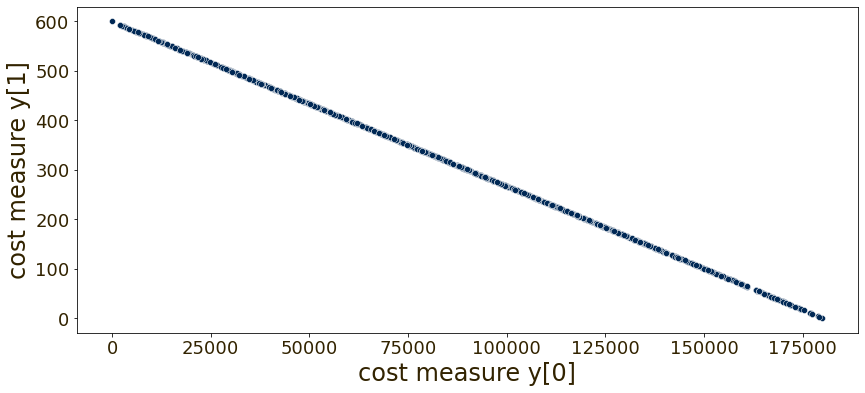

In [8]:
# visualize the whole Pareto front, projected to y[0] and y[2], not showing y[1]
#
import seaborn as sbn
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("cost measure y[0]", fontsize=24, color="#322300")
ax.set_ylabel("cost measure y[1]", fontsize=24, color="#322300")

# draw the points on the Pareto front jointly with a fifth-order regression
#
sbn.scatterplot(x=pareto_optimal_compromises[0], y=pareto_optimal_compromises[1], \
                color="#002855")

In [9]:
import numpy as np

def square_arrangement(square_size, list_of_values, order_of_indices):
    matrix = np.ndarray((square_size, square_size))
    k = 0
    for i in range(square_size):
        for j in range(square_size-1, -1, -1):
            matrix[i][j] = list_of_values[order_of_indices[k]]
            k += 1
    return matrix

def arrange_indices(square_size, number_of_lists, list_of_lists,\
                    primary_idx, secondary_idx):
    
    index_order_p_idx = [k for (v, k) in\
                         sorted([(v, k) for k, v in\
                                 enumerate(list_of_lists[primary_idx])])]
    index_order_s_idx = [k for (v, k) in\
                         sorted([(v, k) for k, v in\
                                 enumerate(list_of_lists[secondary_idx])])]
    
    index_rank_s = {index_order_s_idx[i]: i for i in range(len(index_order_s_idx))}
    
    order_of_indices = []
    for i in range(square_size-1, -1, -1):
        indices = index_order_p_idx[i*square_size: (i+1)*square_size]
        secondary_ranks = {idx: index_rank_s[idx] for idx in indices}
        secondary_order = [k for (v, k) in sorted([(v, k) for (k, v) in secondary_ranks.items()])]
        for idx in secondary_order:
            order_of_indices.append(idx)
            
    return order_of_indices

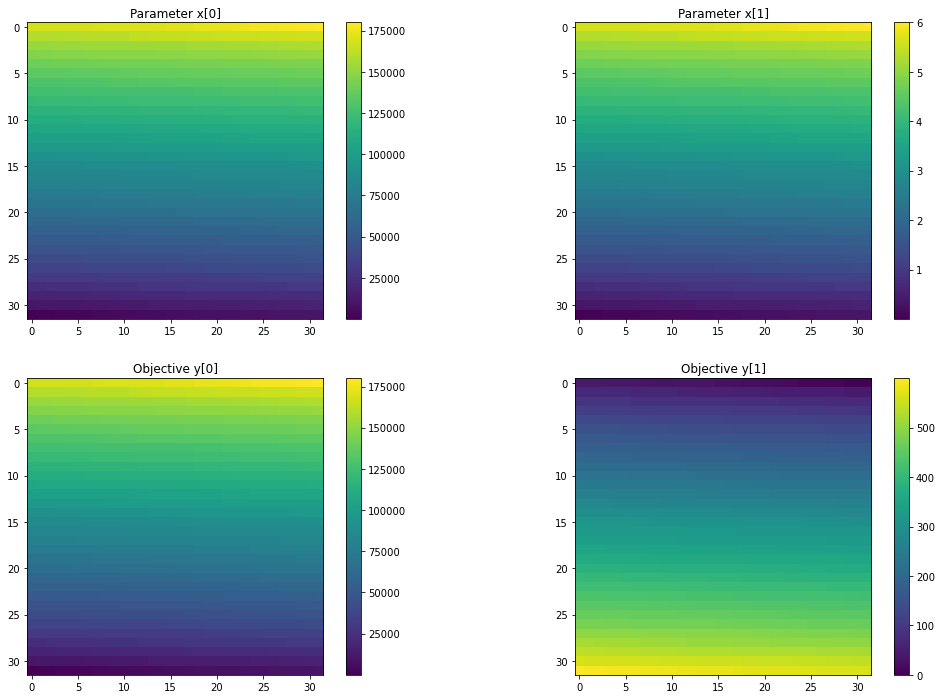

In [10]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, max(m, n))
fig.set_size_inches(18, 12)

square_size = 32
horizontal_id, vertical_id = np.meshgrid(range(square_size), range(square_size-1, -1, -1))

idx_order = arrange_indices(square_size, n, pareto_optimal_compromises, 0, 1)

for i in range(m):
    # look up Pareto optimal parameter values
    #
    pareto_values = square_arrangement(square_size, pareto_optimal_parameters[i], idx_order)

    axs[0, i].set_title("Parameter x[" + str(i) + "]")
    im = axs[0, i].imshow(pareto_values)
    cbar = axs[0, i].figure.colorbar(im, ax=axs[0, i])

for i in range(n):
    # look up values from the Pareto front
    #
    pareto_values = square_arrangement(square_size, pareto_optimal_compromises[i], idx_order)
    axs[1, i].set_title("Objective y[" + str(i) + "]")
    im = axs[1, i].imshow(pareto_values)
    cbar = axs[1, i].figure.colorbar(im, ax=axs[1, i])